# Milestone Project 2: SkimLit

Purpose: Create an NLP model to classify abstracts of medical papers into different categories

Model Architecture: Available https://arxiv.org/abs/1612.05251

## Get Data

We can do so from author's Github repository: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [3]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt   test.txt  train.txt


In [4]:
!bat pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt | head -n 5

###24845963
BACKGROUND	This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .
RESULTS	A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .
RESULTS	Liver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .
RESULTS	Survival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .


In [5]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [7]:
# Prepare data to be used with Model
# Visualize the data

def get_lines(filename):
    """
    Reads filename and returns the lines of text as a list
    """
    with open(filename, "r") as f:
        return f.readlines()

In [8]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

## Think about how we want the data to look

```python
[{'line_number' : 0,
   'target' : 'BACKGROUND',
   'text': 'some text',
   'total_lines': 11}, ...next abstract]
```

In [10]:
def preprocess_test_with_line_number(filename):
    """
    Returns a list of dictionaries of abstract line data

    Takes in filename, reads its contents and sorts through each line,
    extracting things like the label, the text of the sentence, and the line number.
    """

    input_lines = get_lines(filename)
    abstract_lines=""
    abstract_samples = []
    for line in input_lines:
        if line.startswith("###"): # Check to see if the line is an ID line
            abstract_id = line
            abstract_lines = ""
        elif line.isspace(): # Check to see if the line is a new line
            abstract_line_split = abstract_lines.splitlines()
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1]
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split) - 1 # start from 0
                abstract_samples.append(line_data)
        else:
            abstract_lines += line
    return abstract_samples



In [11]:
# Get data from file and preprocess it
import time
time_start = time.perf_counter()
train_samples = preprocess_test_with_line_number(data_dir + "train.txt")
val_samples = preprocess_test_with_line_number(data_dir + "dev.txt") # dev == validation set
test_samples = preprocess_test_with_line_number(data_dir + "test.txt")
time_end = time.perf_counter()
print(f"Time taken to preprocess data: {time_end - time_start:.2f} seconds")
print(len(train_samples), len(val_samples), len(test_samples))

Time taken to preprocess data: 0.18 seconds
180040 30212 30135


In [12]:
# Check the first abstract of the training data
train_samples[:11]

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontari

In [13]:
import pandas as pd 
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,11
6,RESULTS,There was a clinically relevant reduction in t...,6,11
7,RESULTS,The mean difference between treatment arms ( @...,7,11
8,RESULTS,"Further , there was a clinically relevant redu...",8,11
9,RESULTS,These differences remained significant at @ we...,9,11


In [14]:
# Distribution of Labels
train_df["target"].value_counts()


target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

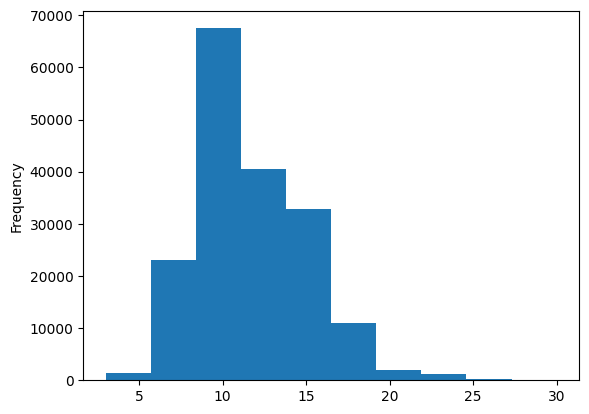

In [15]:
# Length of different lines
train_df.total_lines.plot.hist()

### Get list of sentences

In [16]:
# convert text lines into lists
train_setences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_setences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
# View the first 10 lines of training sentences
train_setences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

<Axes: ylabel='Frequency'>

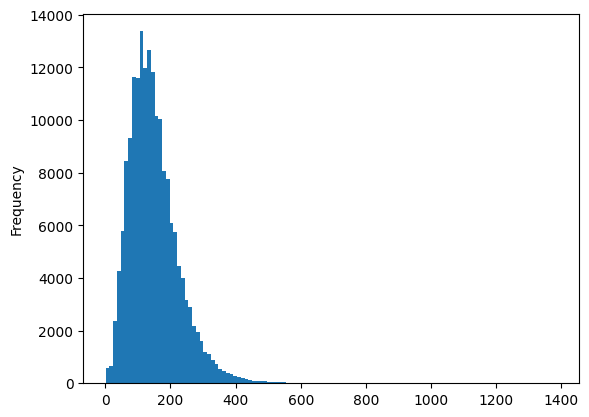

In [18]:
num_bins = len(set([len(sentence.split()) for sentence in train_setences]))
train_df["text"].str.len().plot.hist(bins=120)

<Axes: ylabel='Frequency'>

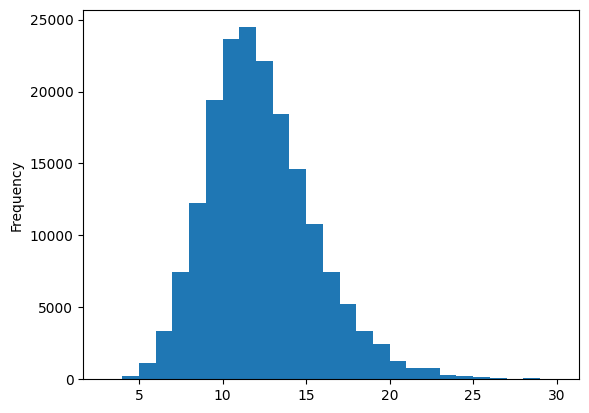

In [19]:
# Number of sentences per abstract
num_bins = len(train_df["total_lines"].unique())
train_df["total_lines"].plot.hist(bins=num_bins)

## Make numeric labels (ML models require numeric labels)

In [20]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
# check what one hot encoded labels look like
train_labels_one_hot
val_labels_one_hot
test_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [21]:
import tensorflow as tf
tf.constant(train_labels_one_hot), tf.constant(val_labels_one_hot), tf.constant(test_labels_one_hot)

(<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
 array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])>,
 <tf.Tensor: shape=(30212, 5), dtype=float64, numpy=
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])>,
 <tf.Tensor: shape=(30135, 5), dtype=float64, numpy=
 array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]])>)

## Label encode labels

In [22]:
# Extract Labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [23]:
# Get class
num_classes = len(label_encoder.classes_)
classes = label_encoder.classes_
print(f"Classes: {classes}")
print(f"Number of classes: {num_classes}")

Classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']
Number of classes: 5


## Baseline Model

 https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

## Model 0: Getting Baseline

In [24]:
# TF-IDF Naive Bayes classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_setences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
# Evaluate the model
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [26]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [27]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-19 14:45:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8000::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.4’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-19 14:45:49 (27.7 MB/s) - ‘helper_functions.py.4’ saved [10246/10246]



In [28]:
from helper_functions import calculate_results
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded, y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [29]:
# Tokenize text
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

In [30]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_setences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

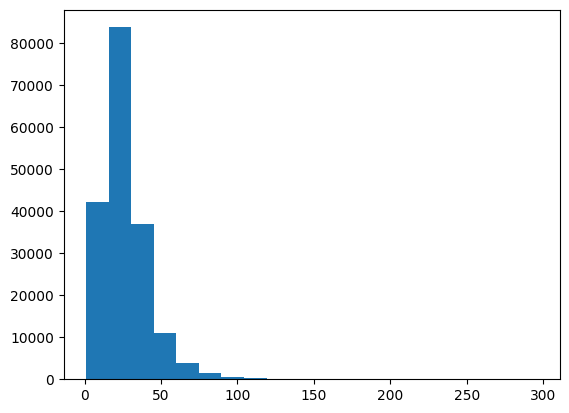

In [31]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [32]:
# How long of a sentence length covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [33]:
# Max sentence length in the training set
max(sent_lens)

296

### Create text vectorizer layers
Convert text into numbers

In [34]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=68_000, # taken from paper; number of words in the vocabulary
    output_sequence_length=output_seq_len,
)


In [35]:
# Adapt text vectorization layer to training sentences
vectorize_layer.adapt(train_setences)

In [36]:
# Test out the vectorizer
import random 
target_sentence = random.choice(train_setences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
vectorized_sentence = vectorize_layer([target_sentence])
print(f"\nVectorized text:\n{vectorized_sentence}")
print(f"\nLength of vectorized text: {len(vectorized_sentence[0])}")


Text:
And subjects ' @ @ m race time in experimental group was obviously shortened than that in control group in hot-humid environment ( t = @ , P < @ ) .

Length of text: 32

Vectorized text:
[[    3   104   358  2468    63     5   409    13    10  2457  4297    42
     28     5    35    13     5 18632  1669   206    14     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Length of vectorized text: 55


In [37]:
# How many words in our training vocabulary
rct_20k_text_vocab = vectorize_layer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}")

Number of words in vocabulary: 64841


In [38]:
# Most common words in the vocabulary
most_common_words = rct_20k_text_vocab[:20]
least_common_words = rct_20k_text_vocab[-20:]
print(f"Most common words in vocab: {most_common_words}")
print(f"Least common words in vocab: {least_common_words}")

Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were', 'was', 'for', 'patients', 'group', 'p', 'at', 'or', 'study', 'on', 'treatment']
Least common words in vocab: ['abandon', 'abaloparatideinduced', 'abagovomabinduced', 'abacus', 'abacopd', 'abacavirlamivudinezidovudine', 'ababa', 'aavsercaa', 'aats', 'aartselaar', 'aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [39]:
# Get the config of our TextVectorization layer
vectorize_layer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'float32',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [40]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), output_dim=128, mask_zero=True, name="token_embedding")


In [41]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = vectorize_layer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")

Sentence before vectorization:
And subjects ' @ @ m race time in experimental group was obviously shortened than that in control group in hot-humid environment ( t = @ , P < @ ) .

Sentence after vectorization (before embedding):
[[    3   104   358  2468    63     5   409    13    10  2457  4297    42
     28     5    35    13     5 18632  1669   206    14     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.02715194 -0.0237057   0.01931811 ... -0.02977014  0.02102374
    0.00834075]
  [ 0.02244134 -0.02945548 -0.04342064 ... -0.04068729 -0.04895998
   -0.04556442]
  [-0.00375353  0.03961469 -0.02106    ...  0.00545045  0.01792618
    0.02560692]
  ...
  [-0.03353846 -0.03267866  0.02747199 ...  0.00226308 -0.00025759
   -0.0314229 ]
  [-0.03353846 -0.03267866  0.02747199 ...  0.00226308 -0.00025

In [42]:
# Create datasets (making sure our data loads as fast as possible)
train_dataset = tf.data.Dataset.from_tensor_slices((train_setences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [43]:
# Prefetch and batch the datasets
train_dataset = train_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
model_1 = tf.keras.Sequential([
    vectorize_layer,
    token_embed,
    layers.Conv1D(32, kernel_size=5, padding="same", activation="relu"),
    layers.Conv1D(64, kernel_size=5, padding="same", activation="relu"),
    layers.GlobalAveragePooling1D(),
    layers.Dense(num_classes, activation="softmax")
], name="model_1_conv1D")

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
history_model_1 = model_1.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs=3, 
            validation_data=valid_dataset,
            validation_steps=int(0.1*len(valid_dataset)),
            callbacks=[])

Epoch 1/3


/Users/calwetzel/.pyenv/versions/3.11.7/envs/DLplayground/lib/python3.11/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5330 - loss: 1.1229 - val_accuracy: 0.7334 - val_loss: 0.7072
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7357 - loss: 0.6962 - val_accuracy: 0.7470 - val_loss: 0.6582
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7618 - loss: 0.6356 - val_accuracy: 0.7773 - val_loss: 0.6008


In [45]:
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7789 - loss: 0.6051


[0.6100095510482788, 0.7779028415679932]

In [46]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


array([[4.0812960e-01, 1.5093179e-01, 1.3995928e-01, 2.7168691e-01,
        2.9292306e-02],
       [4.7321606e-01, 2.6757210e-01, 6.7700567e-03, 2.4889243e-01,
        3.5493150e-03],
       [1.4152317e-01, 3.2972107e-03, 1.3641739e-03, 8.5381019e-01,
        5.3100675e-06],
       ...,
       [1.0065671e-05, 2.0212254e-03, 1.1053433e-02, 6.5220565e-06,
        9.8690873e-01],
       [5.9046663e-02, 4.8539287e-01, 7.6780453e-02, 4.1228388e-02,
        3.3755156e-01],
       [1.6238213e-01, 6.6157460e-01, 2.0869054e-02, 6.5535814e-02,
        8.9638337e-02]], dtype=float32)

In [47]:
# Convert pred probs to classes
mode_1_preds = tf.argmax(model_1_pred_probs, axis=1)
# Classes names
class_predictions = [classes[i] for i in mode_1_preds]
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded, y_pred=mode_1_preds)
model_1_results

{'accuracy': 77.79028200714949,
 'precision': 0.7759671593313706,
 'recall': 0.7779028200714948,
 'f1': 0.7759229090910911}

## Model 2: Feature extraction with pretrained token embeddings

In [48]:
# Use pretrained word embeddings -- USE  
# https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")


In [49]:
import random
random_train_sentence = random.choice(train_setences)
print(f"Random sentence:\n{random_train_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence}\n")
print(f"Sentence after embedding shape:\n{use_embedded_sentence[0].shape}")

Random sentence:
Other voiding parameters and quality of life significantly improved at week @ in both the groups .

Sentence after embedding:
[[-0.02580872 -0.05942364 -0.00927796  0.00529259 -0.02221851 -0.00890484
   0.01769843 -0.05607159 -0.0770602   0.05452407  0.01759709  0.05796593
  -0.04819806  0.0288578  -0.01530658  0.03923806 -0.01152979 -0.01509014
   0.04443565  0.02582699  0.06757227  0.03946114 -0.02823535  0.02643952
   0.00136632  0.00532972 -0.01702386  0.07530527 -0.09906951 -0.02529604
   0.05553687  0.07637592 -0.00654046 -0.00544832 -0.00912858 -0.04782932
  -0.01584535 -0.05728804 -0.02861139  0.06175232 -0.00917083 -0.00209954
   0.04868368 -0.03312788 -0.02336106 -0.06925782 -0.00717422 -0.05632705
   0.0089206   0.02753176 -0.0221205  -0.00623475 -0.01410464  0.01075797
  -0.03382162  0.0714962  -0.08567764  0.0414979  -0.04161481 -0.00061427
  -0.04891877  0.0485665   0.04834224  0.06522396  0.0454114   0.06908198
   0.07318608 -0.04133028 -0.00848942 -0.03

In [50]:
class MyLayer(layers.Layer):
    def call(self, inputs):
        return tf_hub_embedding_layer(inputs)

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = MyLayer()(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs,
                        name="model_2_USE")

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
history_model_2 = model_2.fit(train_dataset,
                                epochs=3,
                                steps_per_epoch=int(0.1*len(train_dataset)),
                                validation_data=valid_dataset,
                                validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5821 - loss: 1.0926 - val_accuracy: 0.6898 - val_loss: 0.7976
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7042 - loss: 0.7713 - val_accuracy: 0.7141 - val_loss: 0.7543
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7146 - loss: 0.7532 - val_accuracy: 0.7181 - val_loss: 0.7278


In [51]:
model_2.summary()

Model: "model_2_USE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_layer (MyLayer)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,929 (777.07 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 132,620 (518.05 KB)

In [52]:
model_2.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7144 - loss: 0.7382


[0.7396199703216553, 0.7147490978240967]

In [53]:
# make predictions with model_2
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


array([[4.3535185e-01, 3.7390256e-01, 2.8263647e-03, 1.7875621e-01,
        9.1631003e-03],
       [3.5000628e-01, 5.1188892e-01, 4.9014143e-03, 1.2966998e-01,
        3.5333540e-03],
       [2.3644088e-01, 1.5062486e-01, 1.9592762e-02, 5.5118167e-01,
        4.2159803e-02],
       ...,
       [1.8855925e-03, 4.6083229e-03, 5.5313881e-02, 8.6635444e-04,
        9.3732584e-01],
       [3.7936515e-03, 4.5715820e-02, 1.6711739e-01, 1.1876848e-03,
        7.8218555e-01],
       [1.5891531e-01, 3.0702132e-01, 4.7537789e-01, 5.6518023e-03,
        5.3033777e-02]], dtype=float32)

In [54]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_results = calculate_results(y_true=val_labels_encoded, y_pred=model_2_preds)
model_2_results

{'accuracy': 71.47491063153714,
 'precision': 0.7148860500513855,
 'recall': 0.7147491063153714,
 'f1': 0.7118723022554959}

In [55]:
baseline_results, model_1_results, model_2_results

({'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294},
 {'accuracy': 77.79028200714949,
  'precision': 0.7759671593313706,
  'recall': 0.7779028200714948,
  'f1': 0.7759229090910911},
 {'accuracy': 71.47491063153714,
  'precision': 0.7148860500513855,
  'recall': 0.7147491063153714,
  'f1': 0.7118723022554959})

## Model 3: Conv1D with character embeddings

### Creating a character-level tokenizer 

In [56]:
train_setences[:5]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .']

In [57]:
def split_chars(text):
    return " ".join(list(text))

In [58]:
split_chars(train_setences[0])

'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .'

In [59]:
train_chars = [split_chars(sentence) for sentence in train_setences]

In [60]:
train_chars[:5]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
 'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [61]:
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [62]:
# Average char length
char_lens = [len(sentence) for sentence in train_setences]
avg_char_len = np.mean(char_lens)
avg_char_len

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <BarContainer object of 20 artists>)

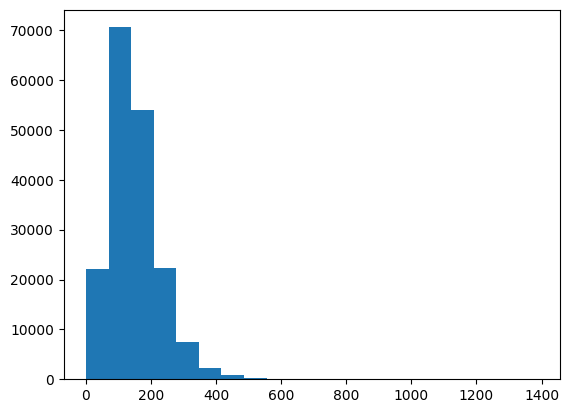

In [63]:
plt.hist(char_lens, bins=20)

In [64]:
# What char length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [65]:
# Get all keyboard chars
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [66]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS, output_sequence_length=output_seq_char_len, name="char_vectorizer")
char_vectorizer.adapt(train_chars)


In [67]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in the vocabulary: {len(char_vocab)}")
print(f"Most common characters in the vocabulary: {char_vocab[:5]}")
print(f"Least common characters in the vocabulary: {char_vocab[-5:]}")

Number of different characters in the vocabulary: 28
Most common characters in the vocabulary: ['', '[UNK]', 'e', 't', 'i']
Least common characters in the vocabulary: ['k', 'x', 'z', 'q', 'j']


In [68]:
#NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
#char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS, standardize=None, output_sequence_length=output_seq_char_len, name="char_vectorizer")
#char_vectorizer.adapt(train_chars)

In [69]:
#char_vocab = char_vectorizer.get_vocabulary()
#print(f"Number of different characters in the vocabulary: {len(char_vocab)}")
#print(f"Most common characters in the vocabulary: {char_vocab[:5]}")
#print(f"Least common characters in the vocabulary: {char_vocab[-5:]}")

In [70]:
random_train_chars = random.choice(train_chars)
print(f"Random characters:\n{random_train_chars}\n")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized characters:\n{vectorized_chars}\n")
print(f"Length of vectorized characters: {len(vectorized_chars[0])}")


Random characters:
S i x t y - n i n e   p e r c e n t   o f   p a t i e n t s   a c h i e v e d   t r e a t m e n t   s u c c e s s   w i t h   m e t h o t r e x a t e   a n d   @   %   w i t h   m y c o p h e n o l a t e   m o f e t i l   (   P   =   @   )   .

Vectorized characters:
[[ 9  4 24  3 19  6  4  6  2 14  2  8 11  2  6  3  7 17 14  5  3  4  2  6
   3  9  5 11 13  4  2 21  2 10  3  8  2  5  3 15  2  6  3  9 16 11 11  2
   9  9 20  4  3 13 15  2  3 13  7  3  8  2 24  5  3  2  5  6 10 20  4  3
  13 15 19 11  7 14 13  2  6  7 12  5  3  2 15  7 17  2  3  4 12 14  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

### Creating a character level embedding

In [108]:
char_emed = layers.Embedding(input_dim=len(char_vocab), output_dim=25, # 25 is the output_dim from the paper
                             mask_zero=False, name="char_embed")

In [109]:
# Test out character embedding layer
print(f"Charified text:\n{random_train_chars}\n")
char_embed_example = char_vectorizer([random_train_chars])
print(f"Embedded chars:\n{char_emed(char_embed_example)}\n")
print(f"Embedded chars shape:\n{char_emed(char_embed_example).shape}")


Charified text:
S i x t y - n i n e   p e r c e n t   o f   p a t i e n t s   a c h i e v e d   t r e a t m e n t   s u c c e s s   w i t h   m e t h o t r e x a t e   a n d   @   %   w i t h   m y c o p h e n o l a t e   m o f e t i l   (   P   =   @   )   .

Embedded chars:
[[[-0.01844976  0.0002665  -0.03024583 ... -0.03099136  0.00756739
   -0.00707721]
  [-0.00233702  0.00243564 -0.0137336  ... -0.03325919 -0.0122772
   -0.01013368]
  [ 0.03897895 -0.04513903  0.04710182 ... -0.01035626  0.0064215
    0.01735539]
  ...
  [-0.01302125 -0.02777857 -0.02171732 ...  0.02724839  0.00504085
   -0.00214745]
  [-0.01302125 -0.02777857 -0.02171732 ...  0.02724839  0.00504085
   -0.00214745]
  [-0.01302125 -0.02777857 -0.02171732 ...  0.02724839  0.00504085
   -0.00214745]]]

Embedded chars shape:
(1, 290, 25)


In [110]:
# Conv1D with character embeddings
inputs = layers.Input(shape=(1,), dtype="string") # 1 sequence at a time
char_vectors = char_vectorizer(inputs)
char_embeddings = char_emed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1D_char_embedding")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_conv1D_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embed (Embedding)          │ (None, 290, 25)        │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [111]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [112]:
history_model_3 = model_3.fit(train_char_dataset,
                                steps_per_epoch=int(0.1*len(train_char_dataset)),
                                epochs=3,
                                validation_data=valid_char_dataset,
                                validation_steps=int(0.1*len(valid_char_dataset)))


Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4389 - loss: 1.3694 - val_accuracy: 0.5921 - val_loss: 1.0235
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5802 - loss: 1.0281 - val_accuracy: 0.6340 - val_loss: 0.9375
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6286 - loss: 0.9344 - val_accuracy: 0.6572 - val_loss: 0.8769


In [113]:
# Make predictions with character model
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[0.16053876, 0.38129205, 0.08563218, 0.32075664, 0.05178029],
       [0.1280746 , 0.5425749 , 0.00711122, 0.2797373 , 0.04250199],
       [0.0799366 , 0.31707418, 0.15090856, 0.40996876, 0.04211194],
       ...,
       [0.02164584, 0.0405599 , 0.20809971, 0.02165898, 0.7080356 ],
       [0.02411195, 0.13237901, 0.37524703, 0.04585804, 0.42240402],
       [0.46275416, 0.30940887, 0.11783734, 0.10111032, 0.00888932]],
      dtype=float32)

In [114]:
# convert pred probs to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_results = calculate_results(y_true=val_labels_encoded, y_pred=model_3_preds)
model_3_results

{'accuracy': 65.59314179796107,
 'precision': 0.6516911222531839,
 'recall': 0.6559314179796107,
 'f1': 0.6465590293137564}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)
1. Create token-level model (similar to `model_1`)
2. Create character-level model (similar to `model_3` with slight modification)
3. Combine 1 and 2 with `tf.keras.layers.Concatenate`
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [115]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype="string", name="token_input")
token_embeddings = MyLayer()(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_emed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM from the character-level embeddings in the paper
char_model = tf.keras.Model(inputs=char_inputs,
                           outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                        outputs=output_layer,
                        name="model_4_token_and_char_embeddings")

model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # SGD from the paper
                metrics=["accuracy"])


In [116]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer_4          │ (None, 512)       │          0 │ token_input[0][0] │
│ (MyLayer)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 25)   │        700 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │     65,664 │ my_layer_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 48)        │      9,600 │ char_embed[1][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid   │ (None, 176)       │          0 │ dense_16[0][0],   │
│ (Concatenate)       │                   │            │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 176)       │          0 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 128)       │     22,656 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 5)         │        645 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 99,265 (387.75 KB)

 Trainable params: 99,265 (387.75 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
# Open Netron app and use it to display model architecture. 
model_4.save("concat_model.keras")

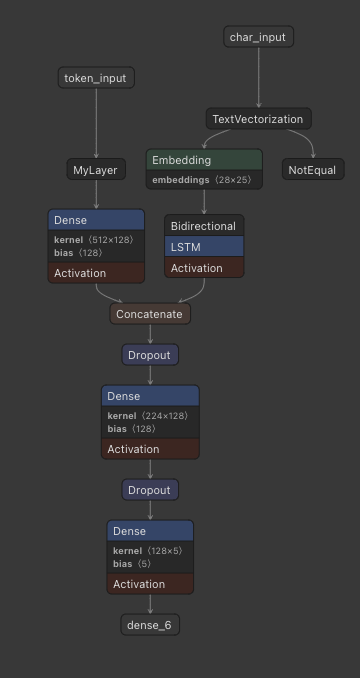

In [118]:
from IPython.display import Image
Image("model_4_architecture.png")

In [119]:
# Dataset for token and character inputs
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_setences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels; they both share the same target
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same for validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do for test data
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [120]:
# Check out data sets
for sample in train_char_token_dataset.take(1).as_numpy_iterator(): # should be token first, char second, target third
    print(sample)
train_char_token_dataset

((array([b'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
       b'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       b'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       b'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
       b'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
       b'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hs

2024-05-19 15:01:36.094702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [121]:
# Fit the multimodal model
history_model_4 = model_4.fit(train_char_token_dataset,
                            steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                            epochs=3,
                            validation_data=val_char_token_dataset,
                            validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 34s 58ms/step - accuracy: 0.5133 - loss: 1.1771 - val_accuracy: 0.6912 - val_loss: 0.8060
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/step - accuracy: 0.6851 - loss: 0.8143 - val_accuracy: 0.7227 - val_loss: 0.7256
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 35s 62ms/step - accuracy: 0.7038 - loss: 0.7819 - val_accuracy: 0.7337 - val_loss: 0.6953


In [122]:
model_4.evaluate(val_char_token_dataset)

  1/945 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.4062 - loss: 1.0178

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7313 - loss: 0.6988


[0.6993626356124878, 0.731431245803833]

In [123]:
# Make predictions with the multimodal model
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(y_true=val_labels_encoded, y_pred=model_4_preds)
model_4_results

945/945 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step


{'accuracy': 73.14312193830266,
 'precision': 0.7307263362904284,
 'recall': 0.7314312193830266,
 'f1': 0.7284379083088177}

In [124]:
model_1_results

{'accuracy': 77.79028200714949,
 'precision': 0.7759671593313706,
 'recall': 0.7779028200714948,
 'f1': 0.7759229090910911}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [125]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11


> Note: Any engineered features (lines numbers and total lines) used to train the model need to be available at test time.

### Create positional embeddings

In [126]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

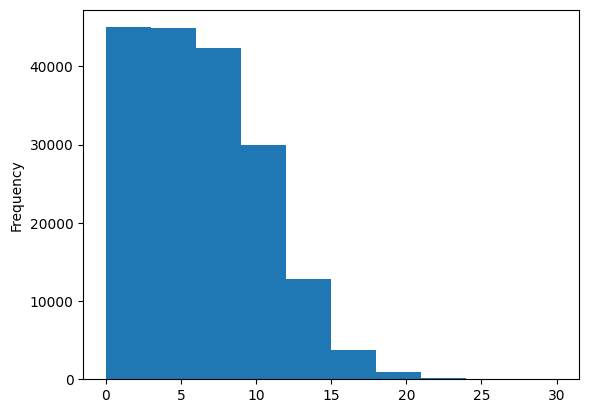

In [127]:
# Check distribution
train_df.line_number.plot.hist()

In [128]:
# One hot encode line numbers
# Don't want the one-hot encoded vector to be too large
# Removes numerical discrepencies between line numbers e.g. 2 vs 4 
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_number_one_hot[:10], train_line_number_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [129]:
train_df["total_lines"].value_counts().sort_index()

total_lines
3        32
4       215
5      1146
6      3353
7      7464
8     12285
9     19400
10    23639
11    24468
12    22113
13    18438
14    14610
15    10768
16     7429
17     5202
18     3344
19     2480
20     1281
21      770
22      759
23      264
24      200
25      182
26       81
27       28
28       58
30       31
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

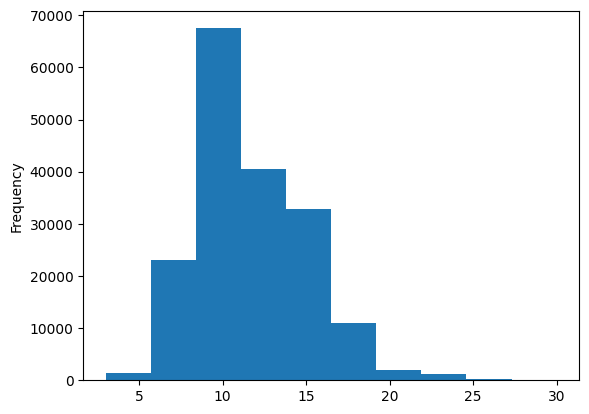

In [130]:
train_df.total_lines.plot.hist()

In [131]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

In [132]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 95)

18.0

### Building a tribrid embedding model

1. Create token level model
2. Create character level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 and 2 using the Concatenate layer
6. Combine the 3, 4, 5 using the Concatenate layer
7. Create an output layer to accept the tribid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3 , 4 and outputs of 7 into a tf.keras.Model



In [160]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_input")
token_embeddings = MyLayer()(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings) 
token_model = tf.keras.Model(inputs=token_inputs,
                            outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_emed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line number inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                    outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                    outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# Dropout Layer
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)



# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")(inputs=[line_number_model.output, total_lines_model.output, z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input, total_lines_model.input, token_model.input, char_model.input],
                        outputs=output_layer,
                        name="model_5_tribrid_model")




In [161]:
model_5.summary()

Model: "model_5_tribrid_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ my_layer_7          │ (None, 512)       │          0 │ token_input[0][0] │
│ (MyLayer)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 25)   │        700 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128)       │     65,664 │ my_layer_7[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 48)        │      9,600 │ char_embed[4][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid   │ (None, 176)       │          0 │ dense_27[0][0],   │
│ (Concatenate)       │                   │            │ bidirectional_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_input   │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_input   │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 256)       │     45,312 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 32)        │        512 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 32)        │        672 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_positio… │ (None, 320)       │          0 │ dense_28[0][0],   │
│ (Concatenate)       │                   │            │ dense_29[0][0],   │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │      1,605 │ char_token_posit… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 124,065 (484.63 KB)

 Trainable params: 124,065 (484.63 KB)

 Non-trainable params: 0 (0.00 B)

In [162]:
model_5.save("model_5_tribrid_model.keras")

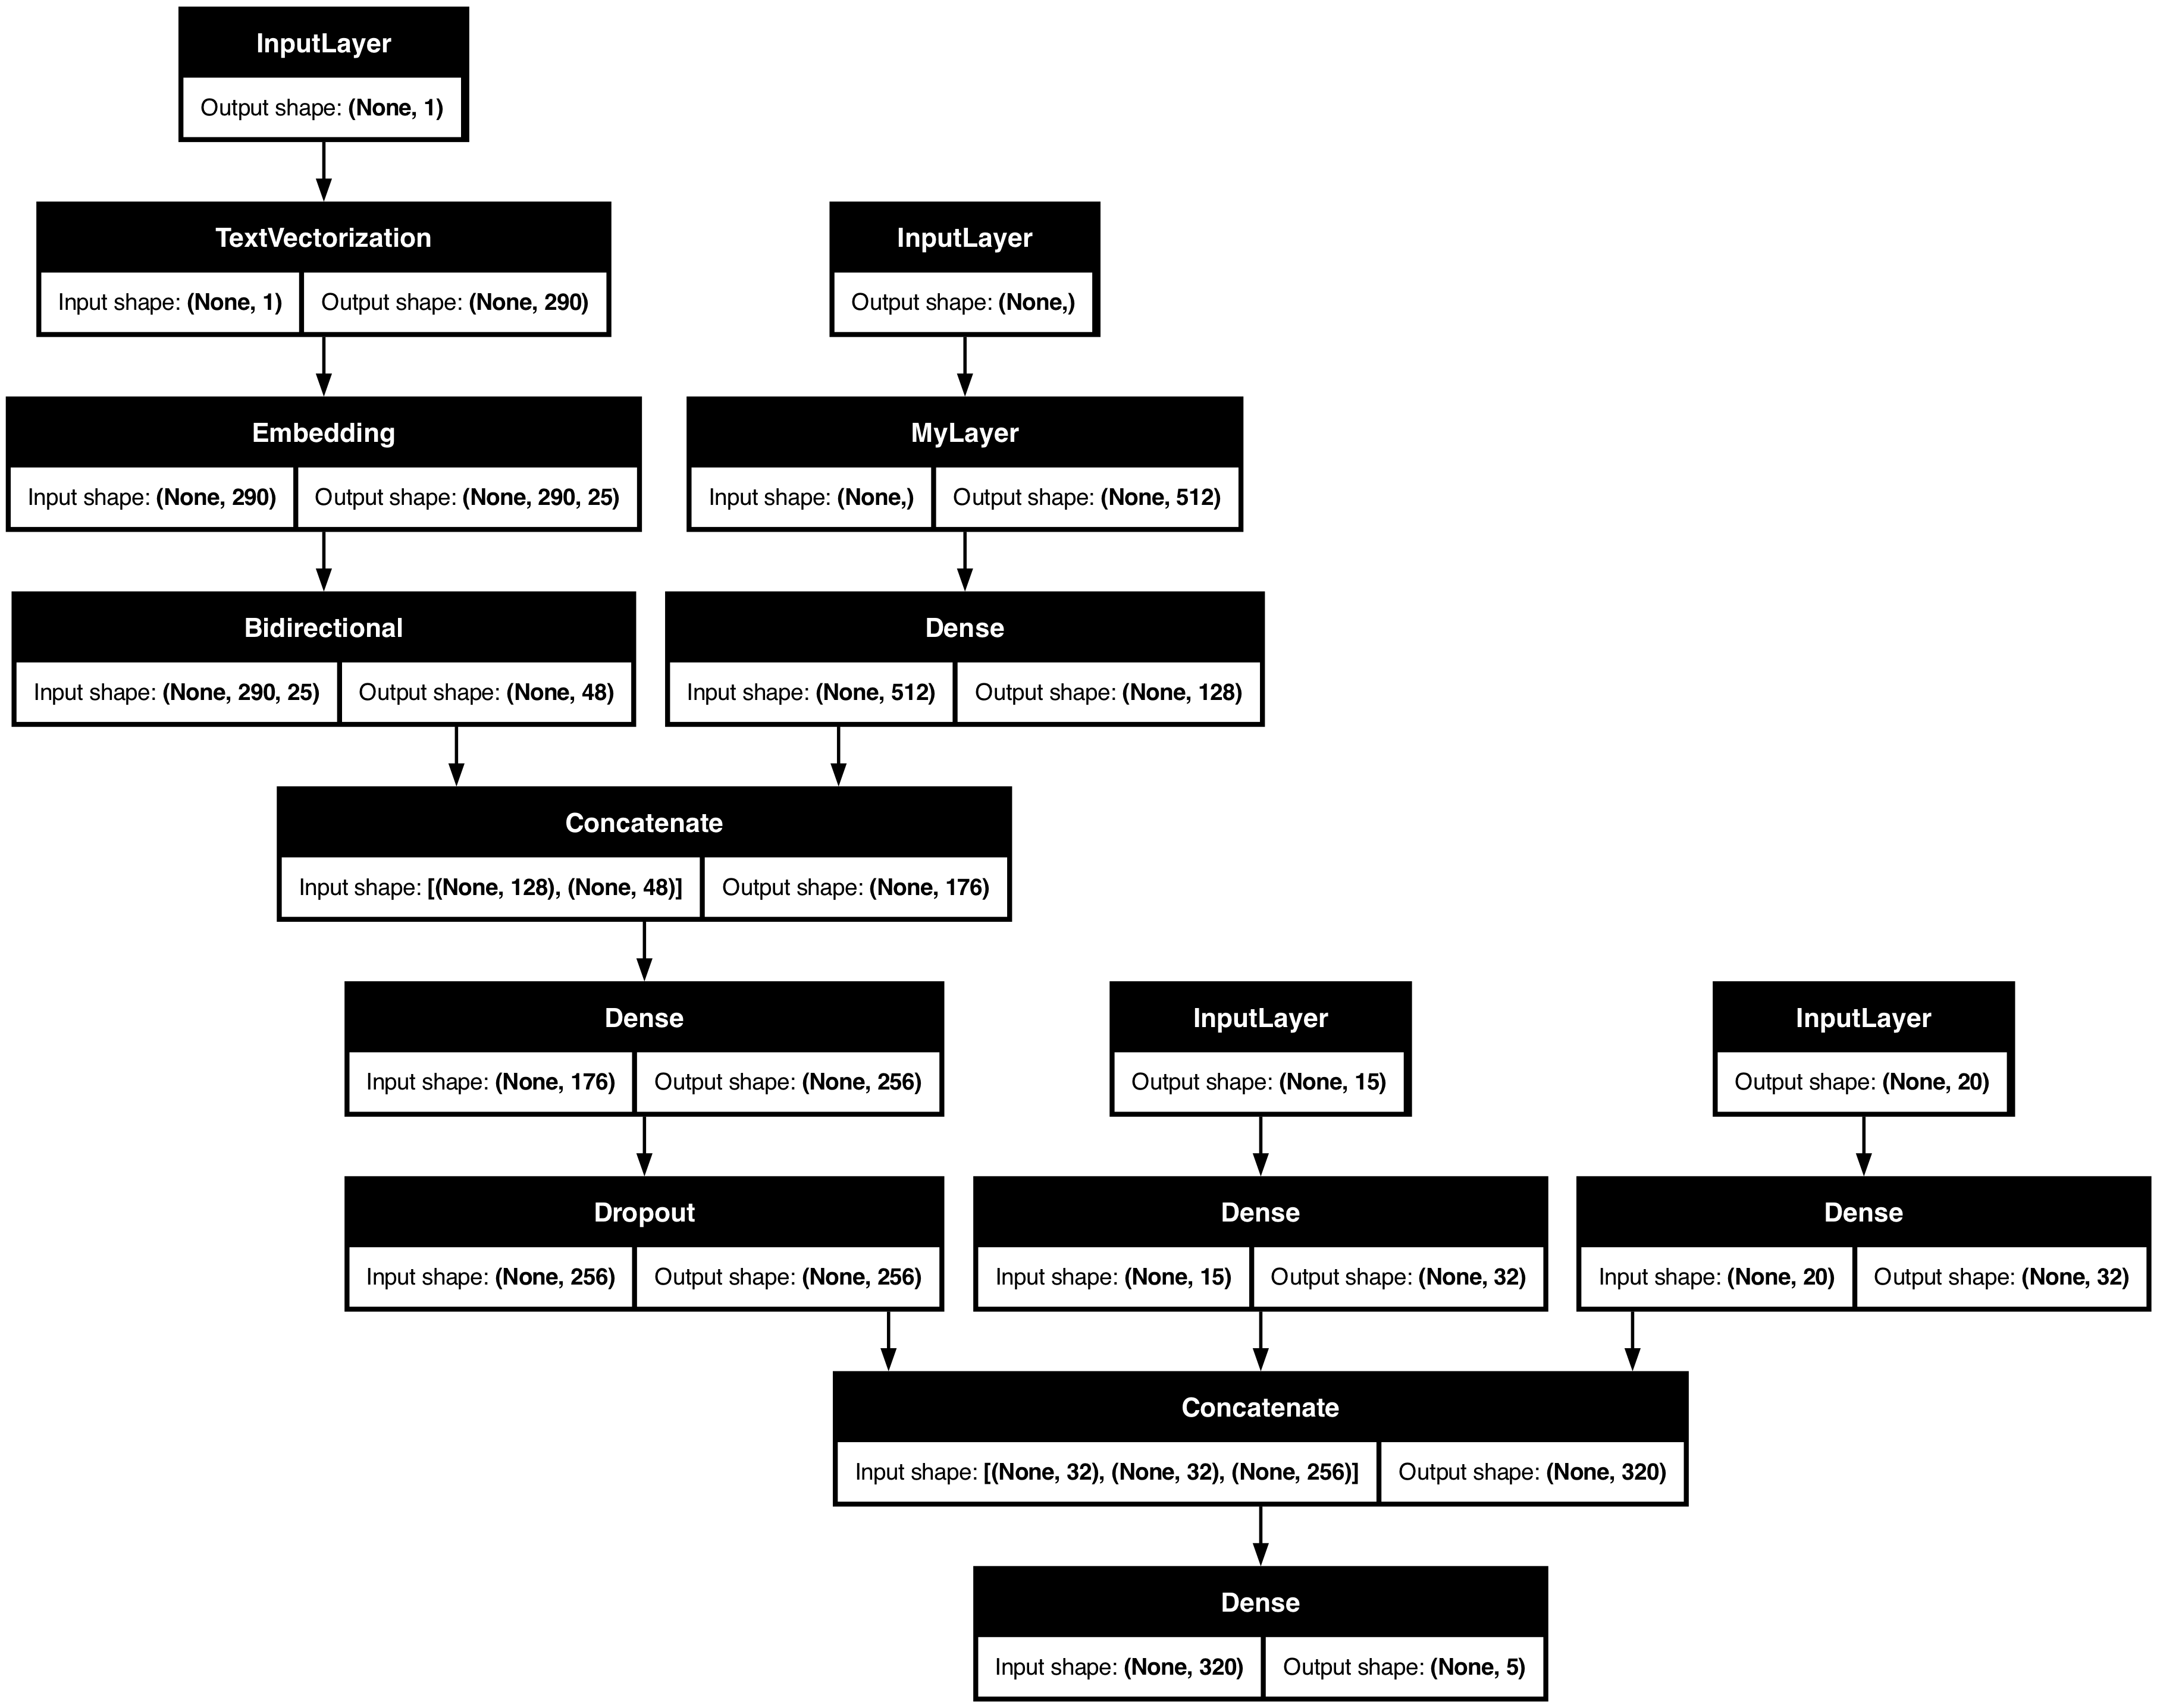

In [163]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [164]:
# Compile the token, char, and positional embeddings model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [165]:
# Create tribrid datasets
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot, train_total_lines_one_hot, train_setences, train_chars))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot, val_total_lines_one_hot, val_sentences, val_chars))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot, test_total_lines_one_hot, test_sentences, test_chars))
test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data, test_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [166]:
# Check out the tribrid dataset
print(train_tribrid_dataset.take(1))
for item in train_tribrid_dataset.take(1):
    print(item)

<_TakeDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>
((<tf.Tensor: shape=(32, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0.

2024-05-19 15:28:46.192377: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [167]:
# Fit the tribrid model
history_model_5 = model_5.fit(train_tribrid_dataset, epochs=3, validation_data=val_tribrid_dataset)

Epoch 1/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 349s 62ms/step - accuracy: 0.7818 - loss: 1.0111 - val_accuracy: 0.8484 - val_loss: 0.9080
Epoch 2/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 345s 61ms/step - accuracy: 0.8506 - loss: 0.9131 - val_accuracy: 0.8535 - val_loss: 0.8998
Epoch 3/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 347s 62ms/step - accuracy: 0.8617 - loss: 0.8993 - val_accuracy: 0.8530 - val_loss: 0.8985


In [168]:
model_5.evaluate(val_tribrid_dataset)

  1/945 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.6875 - loss: 0.9832

945/945 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8503 - loss: 0.8989


[0.8984556794166565, 0.8530385494232178]

In [169]:
# Make predictions with the tribrid model
model_5_pred_probs = model_5.predict(val_tribrid_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(y_true=val_labels_encoded, y_pred=model_5_preds)
model_5_results

945/945 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step


{'accuracy': 85.30385277373229,
 'precision': 0.8551345352642987,
 'recall': 0.8530385277373229,
 'f1': 0.8501036405262761}

In [170]:
model_1_results, model_2_results, model_3_results, model_4_results, model_5_results

({'accuracy': 77.79028200714949,
  'precision': 0.7759671593313706,
  'recall': 0.7779028200714948,
  'f1': 0.7759229090910911},
 {'accuracy': 71.47491063153714,
  'precision': 0.7148860500513855,
  'recall': 0.7147491063153714,
  'f1': 0.7118723022554959},
 {'accuracy': 65.59314179796107,
  'precision': 0.6516911222531839,
  'recall': 0.6559314179796107,
  'f1': 0.6465590293137564},
 {'accuracy': 73.14312193830266,
  'precision': 0.7307263362904284,
  'recall': 0.7314312193830266,
  'f1': 0.7284379083088177},
 {'accuracy': 85.30385277373229,
  'precision': 0.8551345352642987,
  'recall': 0.8530385277373229,
  'f1': 0.8501036405262761})

In [173]:
models_df = pd.DataFrame({  "model_0_baseline": baseline_results,
                            "model_1_custom_token_embedding": model_1_results,
                            "model_2_pretrained_token_embedding": model_2_results,
                            "model_3_custom_char_embedding": model_3_results,
                            "model_4_hybrid_char_token_embedding": model_4_results,
                            "model_5_pos_char_token_embedding": model_5_results})
models_df = models_df.transpose()
models_df["accuracy"] = models_df["accuracy"] / 100
models_df.sort_values("f1", ascending=False)

,accuracy,precision,recall,f1
model_5_pos_char_token_embedding,0.853039,0.855135,0.853039,0.850104
model_1_custom_token_embedding,0.777903,0.775967,0.777903,0.775923
model_4_hybrid_char_token_embedding,0.731431,0.730726,0.731431,0.728438
model_2_pretrained_token_embedding,0.714749,0.714886,0.714749,0.711872
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_3_custom_char_embedding,0.655931,0.651691,0.655931,0.646559


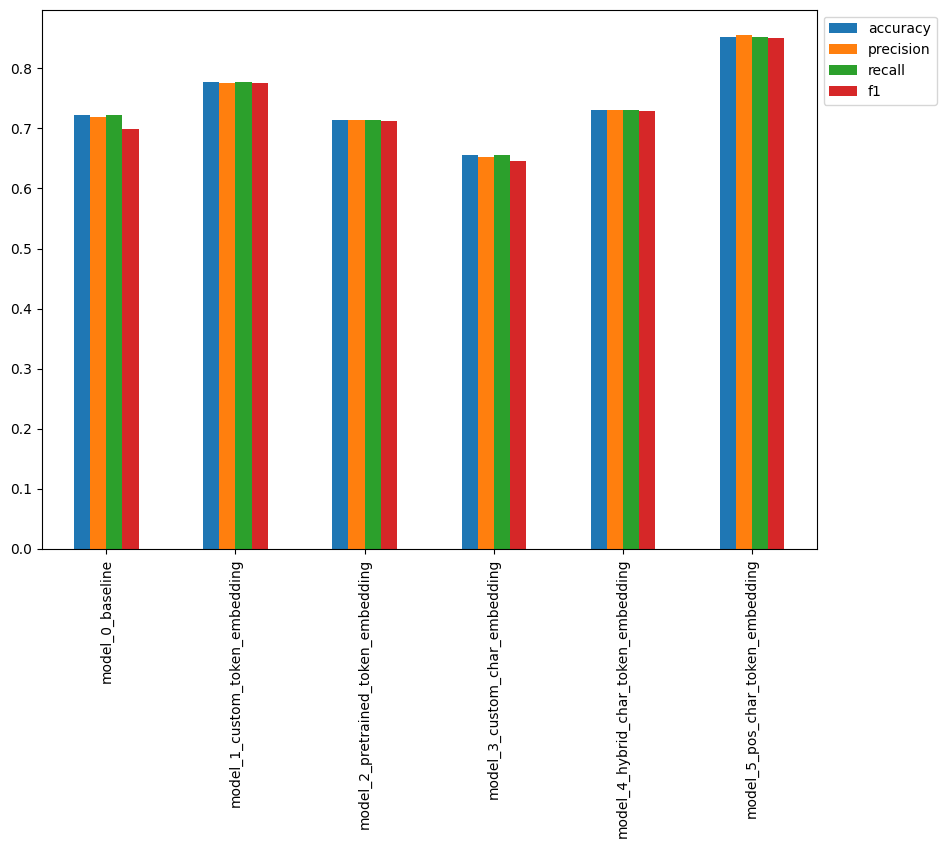

In [174]:
models_df.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

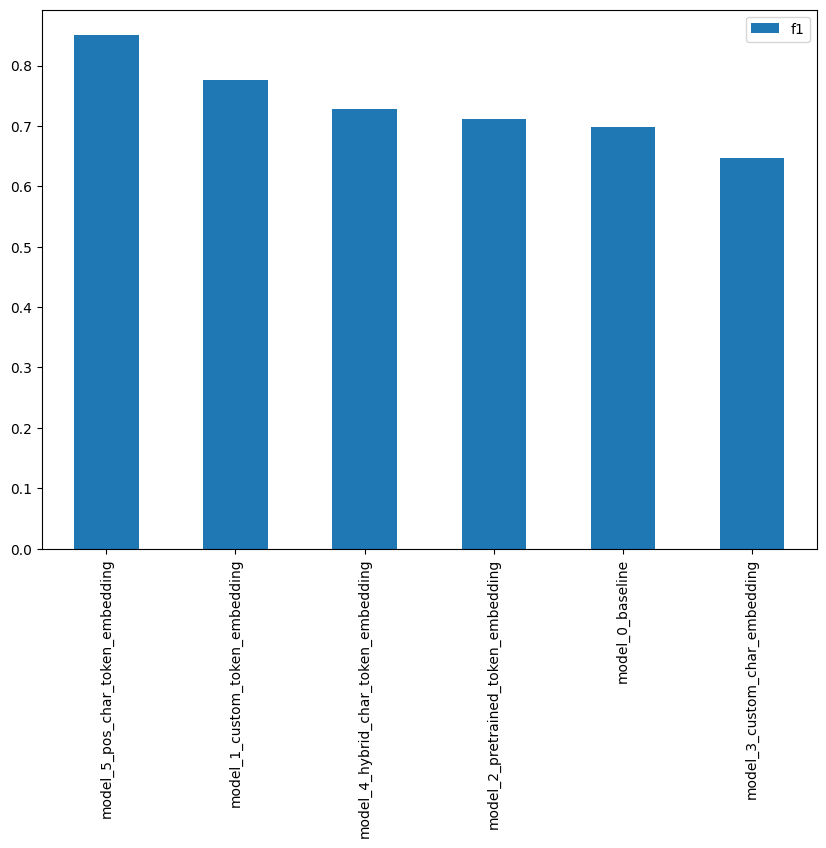

In [177]:
models_df.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

In [186]:
test_pred_probs = model_5.predict(test_tribrid_dataset)


942/942 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step


In [189]:
test_preds = np.argmax(test_pred_probs, axis=1)
test_results = calculate_results(y_true=test_labels_encoded, y_pred=test_preds)
test_results

{'accuracy': 84.86145677783308,
 'precision': 0.8493131024027658,
 'recall': 0.8486145677783309,
 'f1': 0.8455606718529346}